Rows with both DealSize and PostValuation (raw): 12623
Pearson (raw): 0.7200672443970918
Raw OLS slope: 0.48314087648931847 intercept: -9.505287124643075
R2: 0.5184968364536195 RMSE: 1247.2133974122248


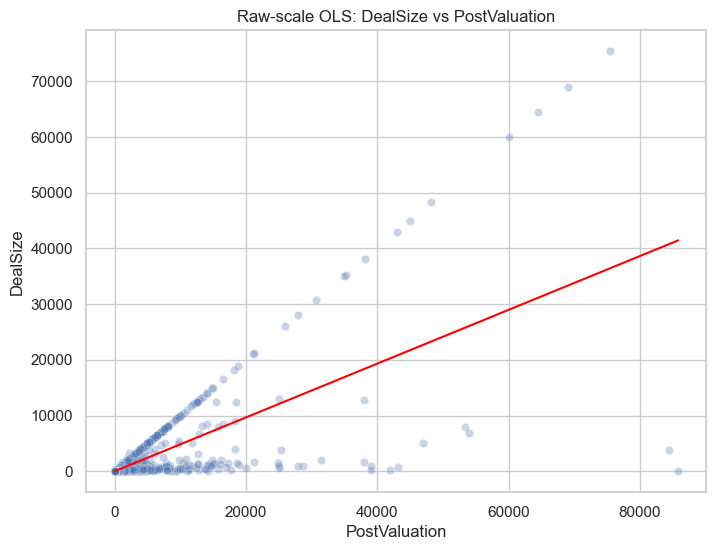

In [11]:
# First pass: non-logged raw analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sns.set(style='whitegrid')

p = Path('deals_joined.parquet')
if p.exists():
    df = pd.read_parquet(p)
else:
    df = pd.read_parquet('deals.parquet')

cols = ['DealSize','PostValuation']

raw = df[cols].dropna().copy()
print('Rows with both DealSize and PostValuation (raw):', len(raw))

# simple Pearson on raw
print('Pearson (raw):', raw['DealSize'].corr(raw['PostValuation']))
# OLS fit on raw scale
raw_pos = raw[(raw['DealSize'] > 0) & (raw['PostValuation'] > 0)]

Xr = raw_pos[['PostValuation']].values
yr = raw_pos['DealSize'].values
lr = LinearRegression().fit(Xr, yr)
ypred = lr.predict(Xr)
raw_rmse = float(np.sqrt(mean_squared_error(yr, ypred)))
print('Raw OLS slope:', float(lr.coef_[0]), 'intercept:', float(lr.intercept_))
print('R2:', r2_score(yr, ypred), 'RMSE:', raw_rmse)
plt.figure(figsize=(8,6))
sns.scatterplot(x='PostValuation', y='DealSize', data=raw_pos, alpha=0.3)
xs = np.linspace(raw_pos['PostValuation'].min(), raw_pos['PostValuation'].max(), 200)
plt.plot(xs, lr.predict(xs.reshape(-1,1)), color='red')
plt.xlabel('PostValuation')
plt.ylabel('DealSize')
plt.title('Raw-scale OLS: DealSize vs PostValuation')
plt.show()


Rows after excluding DealSize==PostValuation: 10764
Pearson (raw, filtered): 0.5524553644239768
Raw OLS slope (filtered): 0.10016314657087139 intercept: 29.680353345750085
R2 (raw, filtered): 0.30520692968082996 RMSE (raw, filtered): 333.64727041135393


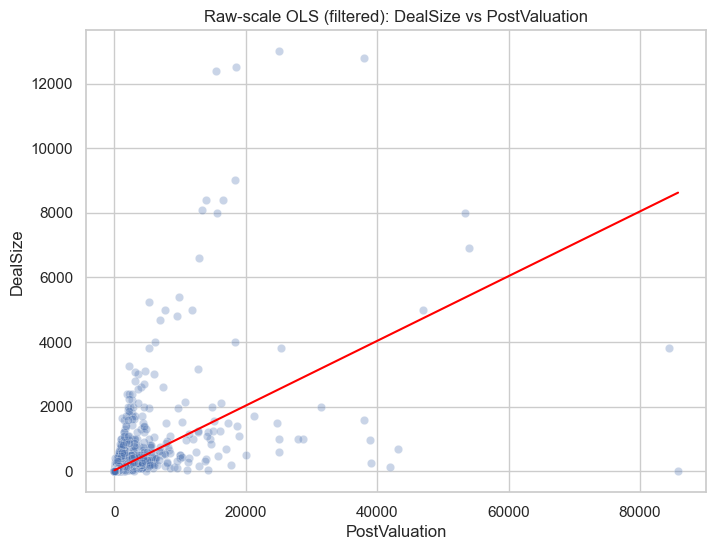

Pearson (log1p, filtered): 0.9103646649268062
Log-log slope (filtered): 0.7984497235586219 intercept: -0.5670669419585521
R2 (log-log, filtered): 0.828763823147295 RMSE (log, filtered): 0.6060778042449408


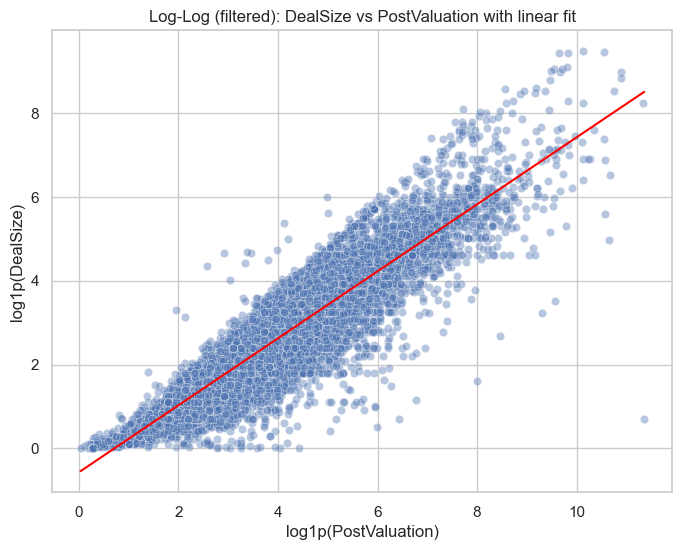

In [12]:
# Second pass: non-logged + log1p analysis excluding DealSize == PostValuation

# reuse df loaded previously if present; else load
try:
    df
except NameError:
    p = Path('deals_joined.parquet')
    if p.exists():
        df = pd.read_parquet(p)
    else:
        df = pd.read_parquet('deals.parquet')

cols = ['DealSize','PostValuation']


sub = df[cols].dropna().copy()
# exclude exact-equal deals where DealSize equals PostValuation (likely synthetic or special cases)
sub = sub[sub['DealSize'] != sub['PostValuation']].copy()
print('Rows after excluding DealSize==PostValuation:', len(sub))


# raw Pearson and raw OLS on filtered set
print('Pearson (raw, filtered):', sub['DealSize'].corr(sub['PostValuation']))
raw_pos = sub[(sub['DealSize'] > 0) & (sub['PostValuation'] > 0)]

Xr = raw_pos[['PostValuation']].values
yr = raw_pos['DealSize'].values
lr = LinearRegression().fit(Xr, yr)
ypred = lr.predict(Xr)
raw_rmse = float(np.sqrt(mean_squared_error(yr, ypred)))
print('Raw OLS slope (filtered):', float(lr.coef_[0]), 'intercept:', float(lr.intercept_))
print('R2 (raw, filtered):', r2_score(yr, ypred), 'RMSE (raw, filtered):', raw_rmse)
plt.figure(figsize=(8,6))
sns.scatterplot(x='PostValuation', y='DealSize', data=raw_pos, alpha=0.3)
xs = np.linspace(raw_pos['PostValuation'].min(), raw_pos['PostValuation'].max(), 200)
plt.plot(xs, lr.predict(xs.reshape(-1,1)), color='red')
plt.xlabel('PostValuation')
plt.ylabel('DealSize')
plt.title('Raw-scale OLS (filtered): DealSize vs PostValuation')
plt.show()


# log1p analysis on filtered set
sub['log_DealSize'] = np.log1p(sub['DealSize'].clip(lower=0))
sub['log_PostVal'] = np.log1p(sub['PostValuation'].clip(lower=0))
print('Pearson (log1p, filtered):', sub['log_DealSize'].corr(sub['log_PostVal']))
X = sub[['log_PostVal']].values
y = sub['log_DealSize'].values
model = LinearRegression().fit(X, y)
ypred = model.predict(X)
log_rmse = float(np.sqrt(mean_squared_error(y, ypred)))
print('Log-log slope (filtered):', float(model.coef_[0]), 'intercept:', float(model.intercept_))
print('R2 (log-log, filtered):', r2_score(y, ypred), 'RMSE (log, filtered):', log_rmse)
plt.figure(figsize=(8,6))
sns.scatterplot(x='log_PostVal', y='log_DealSize', data=sub, alpha=0.4)
xs = np.linspace(sub['log_PostVal'].min(), sub['log_PostVal'].max(), 200)
plt.plot(xs, model.predict(xs.reshape(-1,1)), color='red')
plt.xlabel('log1p(PostValuation)')
plt.ylabel('log1p(DealSize)')
plt.title('Log-Log (filtered): DealSize vs PostValuation with linear fit')
plt.show()

## Interpretation

- The code above reports raw and log-transformed Pearson correlations and fits simple log-log linear models in both directions. The log-log R² is substantial. That indicates a meaningful multiplicative relationship: DealSize roughly scales with valuation as DealSize ∝ PostValuation^a, where *a* is the fitted slope.


